<a href="https://colab.research.google.com/github/TerranceRandolph/DataScienceProject/blob/main/DataScienceProject/Project%20Image%20Classification/IST652_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  |Terrance Randolph | Final Project | Scripting Data Science | IST 652 |

In [ ]:
# --------------------------------------------
import os
import html
from random import sample
from random import seed
import timeit
import sklearn
import numpy as np
import seaborn as sn
import pandas as pd
# --------------------------------------------
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
# --------------------------------------------
import tensorflow as tf
from tensorflow import keras
# --------------------------------------------
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
# --------------------------------------------
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
# --------------------------------------------
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
# --------------------------------------------
from sklearn.externals import joblib
# --------------------------------------------

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



####Model Path

In [ ]:
root_path = '/content/drive/My Drive/Village 3A/Big Data/Scripting for data/'
os.path.exists(root_path)

True

In [ ]:
folder = '{0}RW_Images_32/'.format(root_path)
os.path.exists(folder)

True

#FUNC -- Joblib_Model Pickel

In [ ]:
def StoreModel(mod,fileName):
  # Save to file in the current working directory
  joblib_file = "{0}{1}.pkl".format(root_path,fileName)
  joblib.dump(mod, joblib_file)
  return( joblib_file )

def LoadModel(fileName):
  # Load from file
  joblib_model = joblib.load("{0}{1}.pkl".format(root_path,fileName))
  return( joblib_model )

#FUNC -- Viz Functions

In [ ]:
# --------------------------------------------
def conMtxMap(cf_matrix):
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names],
                      columns = [i for i in class_names])
  plt.figure(figsize = (10,10))
  sn.heatmap(df_cm, annot=True)

# --------------------------------------------
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
# --------------------------------------------
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
# --------------------------------------------
def plot_pred_imgs(prediction, testLabels, testSet):
  # Plot the first X test images, their predicted labels, and the true labels.
  # Color correct predictions in blue and incorrect predictions in red.
  num_rows, num_cols = 5, 3
  num_images = ( num_rows * num_cols )
  plt.figure(figsize=(2*2*num_cols, 2*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, prediction[i], testLabels, testSet)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, prediction[i], testLabels)
  plt.tight_layout()
  plt.show()
# --------------------------------------------

#FUNC -- Viz Loss & Accuracy

In [ ]:
# --------------------------------------------
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(211)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(212)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()
# --------------------------------------------

#FUNC -- Load & Clean Data

In [ ]:
# load train and test dataset
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = cifar10.load_data()
  # one hot encode target values
  train_lbs = trainY
  test_lbs = testY
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return(trainX, trainY, testX, testY, train_lbs, test_lbs)
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

#FUNC -- Define CNN Multi-Layer Model

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
  # -------------------------------------------------------------------------------------------------
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
  # -------------------------------------------------------------------------------------------------
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
  # -------------------------------------------------------------------------------------------------
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY,ep, n_folds=2):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=ep, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(211)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(212)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()
 


In [ ]:
# load train and test dataset
def load_dataset_1():
  (trainX, trainY), (testX, testY) = cifar10.load_data()
  trainX = trainX.reshape((trainX.shape[0], 32, 32, 3))
  testX = testX.reshape((testX.shape[0], 32, 32, 3))
  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return(trainX, trainY, testX, testY)

 
# # scale pixels
# def prep_pixels(train, test):
# 	# convert from integers to floats
# 	train_norm = train.astype('float32')
# 	test_norm = test.astype('float32')
# 	# normalize to range 0-1
# 	train_norm = train_norm / 255.0
# 	test_norm = test_norm / 255.0
# 	# return normalized images
# 	return train_norm, test_norm

#FUNC -- Prepare & Predict New Images

In [ ]:
def create_img_dataset(folder):
  # seed(32)
  x = []
  y = []
  # files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
  for file in sample(os.listdir(folder),26):
      label = file.split('_')[0]
      y.append(label)
      img = plt.imread(folder + file)
      x.append(img)
      print('image label is: ',label)
  return(x,y)


def plot_RW(rw_img, rw_label, predicted_rw):
  # Plot examples of images with data
  plt.figure(figsize=(10,10))
  for i in range(len(rw_img)):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(rw_img[i], cmap=plt.cm.binary)
      if predicted_rw[i] == rw_label[i]:
        color = 'blue'
      else:
        color = 'red'
      plt.xlabel("{0} ({1})".format(class_names[predicted_rw[i]],
                                           str(class_names[rw_label[i]])),color=color) 


def rw_pred_model(mod,rw_img,rw_label,class_names):
  # ------------------------------------------
  rw_lbl, y_pred_rw, prob_rw, image = [], [], [],[]
  # ------------------------------------------
  for x,i in enumerate(rw_img):
    try:
      # ------------------------------------------
      a = np.array(rw_img[0]).reshape((-1,1)).astype('float32')#.flatten()
      c = a.reshape((a.shape[1], a.shape[0]))
      c = c / 255
      # ------------------------------------------
      # load model
      model = LoadModel(mod)
      # ------------------------------------------
      # Make predictions
      y_pred = model.predict(c)
      # ------------------------------------------
      # get prob. of each model for ploting
      prob = model.predict_proba(c)
      # ------------------------------------------
      y_pred_rw.append(np.argmax(y_pred))
      # ------------------------------------------
      prob_rw.append(prob)
      # ------------------------------------------
      rw_lbl.append( class_names.index(rw_label[x]) )
      # ------------------------------------------
      image.append(i)
      # ------------------------------------------
      if rw_label[x] == class_names[np.argmax(y_pred)]:
        print('T ({0})  :  P ({1})  {2}'.format(rw_label[x],
                                        class_names[np.argmax(y_pred)],
                                        html.unescape('&#10004')))
      else:
        print('T ({0})  :  P ({1})  {2}'.format(rw_label[x],
                                        class_names[np.argmax(y_pred)],
                                        html.unescape('&#10006'))) 
    except:
      print(x,rw_label[x],' :  ERROR!\n')
      continue
    # ------------------------------------------
  return(rw_lbl, y_pred_rw, prob_rw,image)
    # ------------------------------------------



def rw_pred_model_2(mod,rw_img,rw_label,class_names):
  # ------------------------------------------
  rw_lbl, y_pred_rw, prob_rw, image = [], [], [], []
  # ------------------------------------------
  for x,i in enumerate(rw_img):
    try:
      a = np.array(rw_img[x]).reshape((-1,1)).astype('float32')
      c = a.reshape((-1, 32,32,3))
      c = c / 255
      # ------------------------------------------
      # load model
      model = LoadModel(mod)
      # ------------------------------------------
      # Make predictions
      y_pred = model.predict(c)
      # ------------------------------------------
      # get prob. of each model for ploting
      prob = model.predict_proba(c)
      # ------------------------------------------
      y_pred_rw.append(np.argmax(y_pred))
      # ------------------------------------------
      prob_rw.append(prob)
      # ------------------------------------------
      rw_lbl.append( class_names.index(rw_label[x]) )
      # ------------------------------------------
      image.append(i)
      # ------------------------------------------
      if rw_label[x] == class_names[np.argmax(y_pred)]:
        print('T ({0})  :  P ({1})  {2}'.format(rw_label[x],
                                        class_names[np.argmax(y_pred)],
                                        html.unescape('&#10004')))
      else:
        print('T ({0})  :  P ({1})  {2}'.format(rw_label[x],
                                        class_names[np.argmax(y_pred)],
                                        html.unescape('&#10006'))) 
    except:
      print(x,rw_label[x],' :  ERROR!\n')
      continue
    # ------------------------------------------
  return(rw_lbl, y_pred_rw, prob_rw,image)
    # ------------------------------------------



####Real World Images Path

In [ ]:
rw_img, rw_label = create_img_dataset(folder)

image label is:  truck
image label is:  frog
image label is:  truck
image label is:  bird
image label is:  automobile
image label is:  bird
image label is:  ship
image label is:  airplane
image label is:  deer
image label is:  ship
image label is:  bird
image label is:  bird
image label is:  horse
image label is:  deer
image label is:  bird
image label is:  automobile
image label is:  frog
image label is:  bird
image label is:  airplane
image label is:  horse
image label is:  frog
image label is:  frog
image label is:  dog
image label is:  bird
image label is:  bird
image label is:  frog


####Set Class Names

In [ ]:
# --------------------------------------------------------------
# Set catagory name
class_names = ['airplane', 'automobile','bird',
               'cat', 'deer', 'dog', 'frog',
               'horse', 'ship','truck']
# --------------------------------------------------------------



---
#LOAD & CLEAN DATA


In [ ]:
# --------------------------------------------------------------
# load dataset
train_images, train_labels, test_images, test_labels, train_lbs,test_lbs= load_dataset()
# --------------------------------------------------------------
# prepare pixel data
train_images, test_images = prep_pixels(train_images, test_images)
# --------------------------------------------------------------
train_img = train_images.reshape((train_images.shape[0],-1)).astype('float32')
test_img  = test_images.reshape((test_images.shape[0],-1)).astype('float32')
train_img = train_img / 255
test_img  = test_img / 255
# --------------------------------------------------------------

170500096/170498071 [==============================] - 4s 0us/step


## Sample for non-CNN Modeling

In [ ]:
# --------------------------------------------------------------
# CREAE SAMPLE DATASET FOR QUICK MODELING
# --------------------------------------------------------------
# causing input error once sample was too large
# ---> ensure sample is numpy arrary
smp_train         = np.array([x for _, x in zip(range(0,50000), train_img)])
smp_test          = np.array([x for _, x in zip(range(0,500), test_img)])
# ---->   ----->   ----->
smp_train_label   = np.array([x for _, x in zip(range(0,50000), train_lbs)])
smp_test_label    = np.array([x for _, x in zip(range(0,500), test_lbs)])
# --------------------------------------------------------------
smp_test_plot     = [x for _, x in zip(range(0,500), test_images)]#test_reshp)
# --------------------------------------------------------------

###Exploratory Data Analysis

In [ ]:
# --------------------------------------------------------------
print(10*'-----','\nNumber of Training images: {0:,}\nNumber of pixels are {1}x{2}\n'.format(train_images.shape[0],
                                                                            train_images.shape[1],
                                                                            train_images.shape[2]))
# --------------------------------------------------------------
print('Number of Testning images: {0:,}\nNumber of pixels are {1}x{2}\n'.format(test_images.shape[0],
                                                                            test_images.shape[1],
                                                                            test_images.shape[2]))
# --------------------------------------------------------------
print('The Training labels are: ',class_names,'\n\n',10*'-----')
# --------------------------------------------------------------
# SAMPLED DATA
# --------------------------------------------------------------
print('Number of Sampled Training images: {0:,}\nSampled flattened pixels to {1}\n'.format(smp_train.shape[0],
                                                                              smp_train.shape[1]))
# --------------------------------------------------------------
print('Number of Sampled Testning images: {0:,}\nSampled flattened pixels to {1}\n'.format(smp_test.shape[0],
                                                                              smp_test.shape[1]))
# --------------------------------------------------------------
print('The Sampled Training labels are: ',class_names,'\n\n',10*'-----')
# --------------------------------------------------------------

-------------------------------------------------- 
Number of Training images: 50,000
Number of pixels are 32x32

Number of Testning images: 10,000
Number of pixels are 32x32

The Training labels are:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

 --------------------------------------------------
Number of Sampled Training images: 50,000
Sampled flattened pixels to 3072

Number of Sampled Testning images: 500
Sampled flattened pixels to 3072

The Sampled Training labels are:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

 --------------------------------------------------


###Data Image Sample

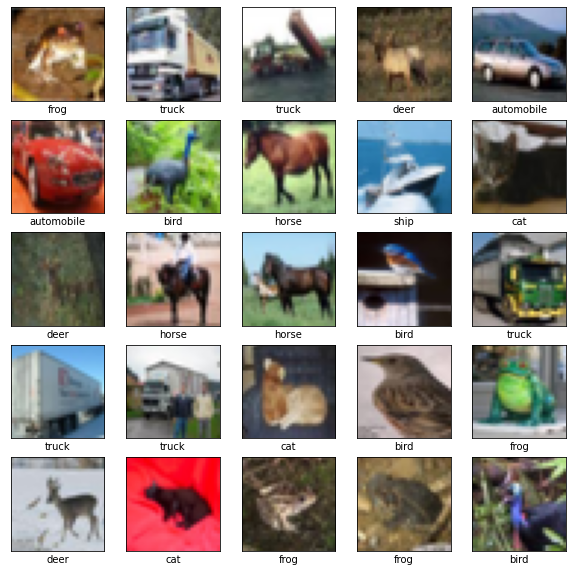

In [ ]:
# --------------------------------------------------------------
# Plot examples of images with data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary) # see if clean images will viz
    # plt.imshow(train_reshape[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_lbs.flatten()[i]])
plt.show()
# --------------------------------------------------------------

###Real World Image Data

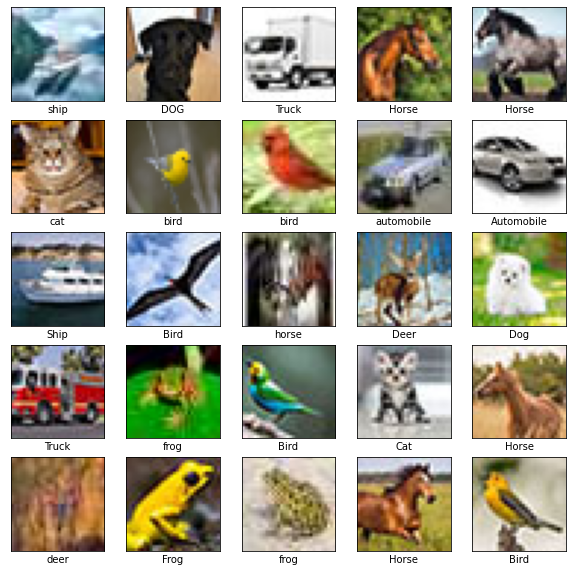

In [ ]:
# --------------------------------------------------------------
# Plot examples of images with data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(rw_img[i], cmap=plt.cm.binary) # see if clean images will viz
    # plt.imshow(train_reshape[i], cmap=plt.cm.binary)
    plt.xlabel(rw_label[i])
plt.show()

#CNN Multi-Layer Model<p>&#11088;&#11088;&#11088;</p>

##Build Model

In [ ]:
# --------------------------------------------------------------
starttime = timeit.default_timer()
# --------------------------------------------------------------
# define model
model = define_model()
# fit model
model.fit(train_images, train_labels, epochs=100, batch_size=32, verbose=1)
# --------------------------------------------------------------
# StoreModel(model,'CNN_mod')
# --------------------------------------------------------------
time_cnn = timeit.default_timer() - starttime
# --------------------------------------------------------------

##Predict | Test Data

In [ ]:
# --------------------------------------------------------------
starttime = timeit.default_timer()
# --------------------------------------------------------------
# load model
mod_cnn  = LoadModel('CNN_mod')
y_pred   = mod_cnn.predict_classes(test_images)
# get prob of predicted
prob_cnn = mod_cnn.predict_proba(test_images)
# --------------------------------------------------------------
predicted   = y_pred
expected    = [np.argmax(i) for i in test_labels]
# create confusion matrix
cf_matrix_cnn = sklearn.metrics.confusion_matrix(expected, predicted)
# # Model Accuracy
acc_cnn = accuracy_score(expected, predicted)
# # ----------------------------------------------------------------------------
metrics_cnn = (metrics.classification_report(expected, predicted,
                                            target_names= class_names))
# --------------------------------------------------------------
time_cnn_p = timeit.default_timer() - starttime
# --------------------------------------------------------------

### Visualize Results | Test Data

Modeled with 10,000 images and tested on 10,000 images

CNN Accuracy is 0.83%

Processing time is 966.83 sec

              precision    recall  f1-score   support

    airplane       0.88      0.83      0.86      1000
  automobile       0.93      0.90      0.91      1000
        bird       0.78      0.75      0.76      1000
         cat       0.66      0.67      0.66      1000
        deer       0.80      0.81      0.80      1000
         dog       0.76      0.74      0.75      1000
        frog       0.83      0.91      0.87      1000
       horse       0.89      0.86      0.87      1000
        ship       0.91      0.91      0.91      1000
       truck       0.85      0.93      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



Raw Confusion Matrix
 [[834  12  27  18  11   3  11   6  48  30]
 [  2 897   2   1   2   5   6   0   9  76]
 [ 34   1 749  44  55

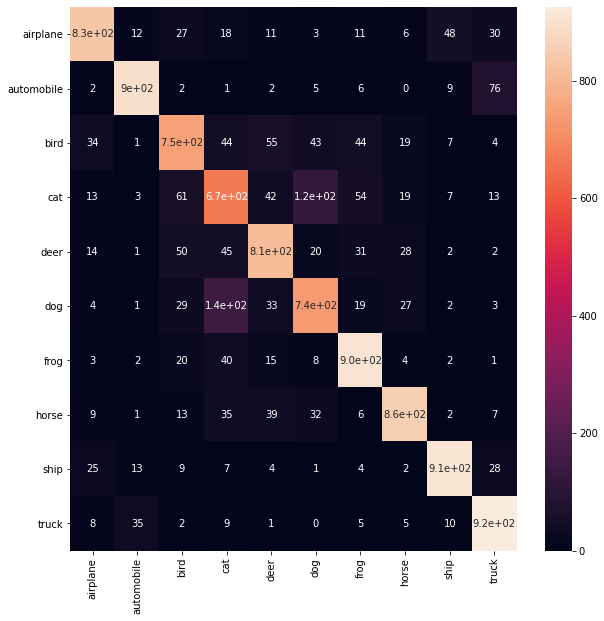

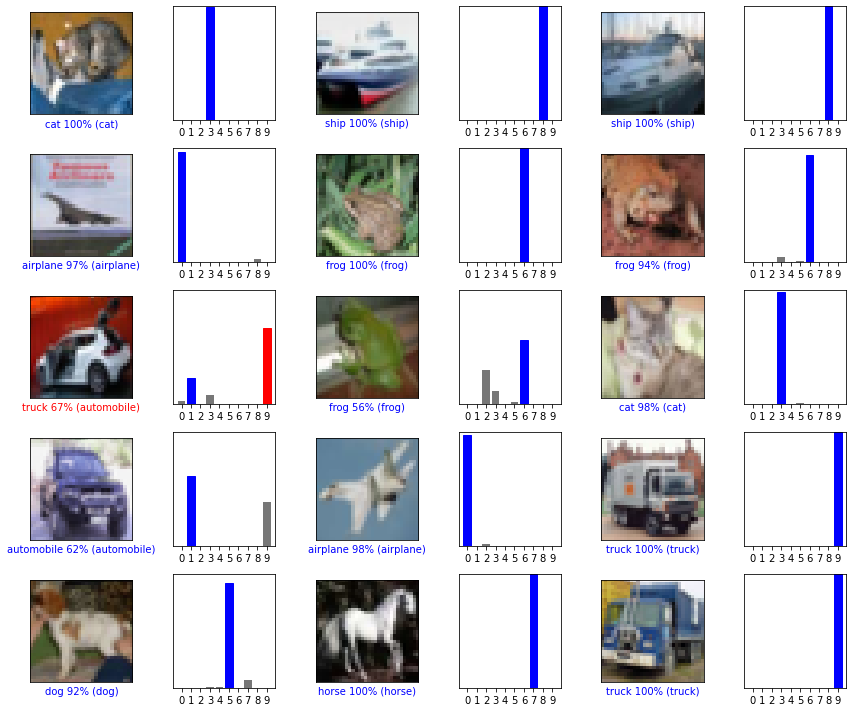

In [ ]:
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(test_images),
                                                                      len(test_images)))
# Model Accuracy
print('CNN Accuracy is {}%\n'.format(str(round(acc_cnn,2))))
# # Processing time
print('Processing time is {} sec\n'.format(str(round(time_cnn,2))))
print(metrics_cnn)
# Viz Confusion Matrix
conMtxMap(cf_matrix_cnn)
# # print raw confusion matrix
print('\n\nRaw Confusion Matrix\n',cf_matrix_cnn,'\n\n')
plot_pred_imgs(prob_cnn, smp_test_label.flatten(), smp_test_plot)

--------------------


##Prediction | Real World

In [ ]:
(rw_lbl, y_pred_rw, prob_rw, img_rw) = rw_pred_model_2('CNN_mod',rw_img,rw_label,class_names)


In [ ]:
# --------------------------------------------------------------
p_rw = y_pred_rw
e_rw = rw_lbl
# create confusion matrix
cf_matrix_rw = sklearn.metrics.confusion_matrix(e_rw, p_rw)
# # Model Accuracy
acc_rw = accuracy_score(e_rw, p_rw)
# # -------------------------------------------------------------
metrics_rw = (metrics.classification_report(e_rw, p_rw,
                                            target_names= class_names))
# --------------------------------------------------------------

###Visualize Results | Real World

Modeled with 50,000 images and tested on 26 images

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00         2
  automobile       1.00      0.50      0.67         2
        bird       1.00      0.80      0.89         5
         cat       0.50      0.50      0.50         2
        deer       1.00      1.00      1.00         2
         dog       0.50      0.50      0.50         2
        frog       0.75      0.75      0.75         4
       horse       1.00      1.00      1.00         2
        ship       0.00      0.00      0.00         2
       truck       0.33      1.00      0.50         1

    accuracy                           0.62        24
   macro avg       0.61      0.60      0.58        24
weighted avg       0.68      0.62      0.64        24

CNN Accuracy On Real World Data 62.5%



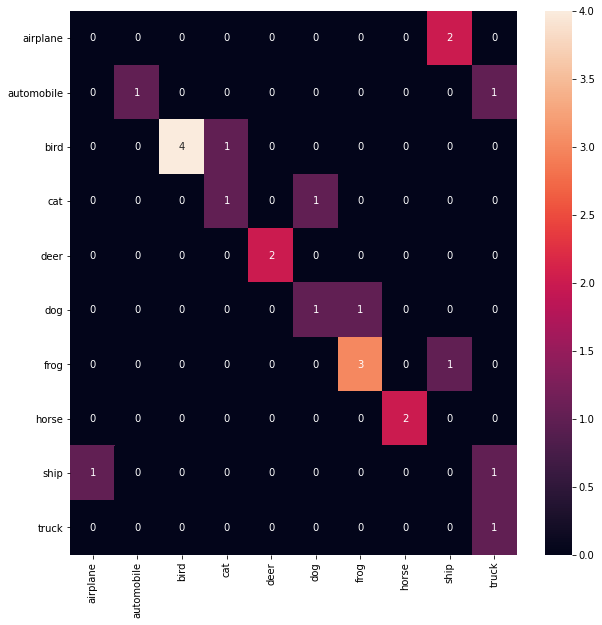

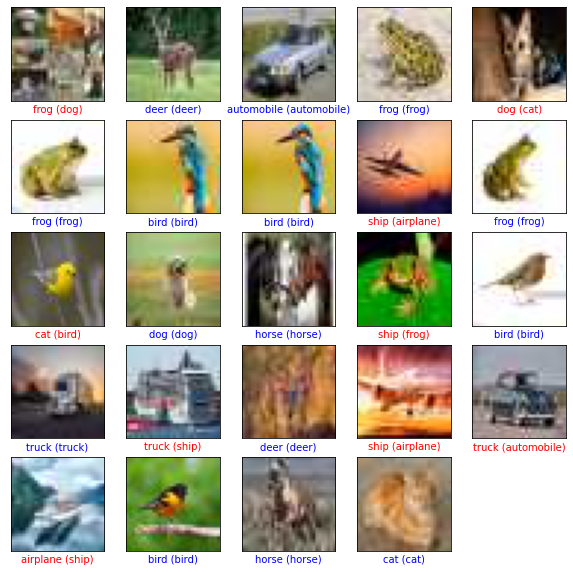

In [ ]:
# ----------------------------------------------------------------------------
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(rw_img)))
print(metrics_rw)
conMtxMap(cf_matrix_rw)
# Model Accuracy
print('CNN Accuracy On Real World Data {}%\n'.format(str(round(acc_rw*100,2))))
plot_RW([i for i in img_rw][:25], rw_lbl[:25], y_pred_rw[:25])# y_pred_rw[:-1])

# MLP Classifier&#11088;&#11088;

##Build Model
Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that you must apply the same scaling to the test set for meaningful results. You can use StandardScaler for standardization.

In [ ]:
scaler = StandardScaler()  # doctest: +SKIP
# Don't cheat - fit only on training data
scaler.fit(smp_train)  # doctest: +SKIP
X_train = scaler.transform(smp_train)  # doctest: +SKIP
# apply same transformation to test data
X_test = scaler.transform(smp_test)  # doctest: +SKIP

In [ ]:
# --------------------------------------------------------------
starttime = timeit.default_timer()
# --------------------------------------------------------------
mlp = MLPClassifier(hidden_layer_sizes=(100,100), activation='relu',
                    solver='sgd', alpha=0.0001,
                    batch_size='auto', learning_rate='constant',
                    learning_rate_init=0.001, power_t=0.5,
                    max_iter=1000, random_state=5, verbose=True)

mlp = mlp.fit(X_train, train_labels)

time_mlp = timeit.default_timer() - starttime
# --------------------------------------------------------------
# 15mins & 275 interations before I stopped process
sv_name = 'MLP_mod'
# save model
StoreModel(mlp, sv_name)
print(time_mlp)

Iteration 1, loss = 3.14009128
Iteration 2, loss = 2.62300733
Iteration 3, loss = 2.51337112
Iteration 4, loss = 2.44221308
Iteration 5, loss = 2.38544225
Iteration 6, loss = 2.33803367
Iteration 7, loss = 2.29701534
Iteration 8, loss = 2.25976069
Iteration 9, loss = 2.22651047
Iteration 10, loss = 2.19623078
Iteration 11, loss = 2.16780346
Iteration 12, loss = 2.14160380
Iteration 13, loss = 2.11635720
Iteration 14, loss = 2.09366361
Iteration 15, loss = 2.07075360
Iteration 16, loss = 2.04823954
Iteration 17, loss = 2.02775852
Iteration 18, loss = 2.00749752
Iteration 19, loss = 1.98803272
Iteration 20, loss = 1.96989613
Iteration 21, loss = 1.95125562
Iteration 22, loss = 1.93379182
Iteration 23, loss = 1.91650393
Iteration 24, loss = 1.89965354
Iteration 25, loss = 1.88318866
Iteration 26, loss = 1.86711255
Iteration 27, loss = 1.85282218
Iteration 28, loss = 1.83708388
Iteration 29, loss = 1.82170660
Iteration 30, loss = 1.80666746
Iteration 31, loss = 1.79208173
Iteration 32, los

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

###Prediction | Test Data

In [ ]:
# --------------------------------------------------------------
starttime = timeit.default_timer()
# --------------------------------------------------------------
# load model
model_mlp = LoadModel('MLP_mod')
y_pred = model_mlp.predict(X_test)
prob_mlp = model_mlp.predict_proba(X_test)
# --------------------------------------------------------------
# fix y pred
y_pred = np.argmax(y_pred, axis=1)
# fix y pred
# create confusion matrix
expected, predicted = smp_test_label, y_pred
cf_matrix_mlp = sklearn.metrics.confusion_matrix(expected, predicted)
# # Model Accuracy
acc_mlp = accuracy_score(smp_test_label, y_pred)
# # ----------------------------------------------------------------------------
metrics_mlp = (metrics.classification_report(smp_test_label, predicted,
                                            target_names= class_names))
# --------------------------------------------------------------
time_mlp_p = timeit.default_timer() - starttime
# --------------------------------------------------------------

####Vizualize Results | Test Data

Modeled with 50,000 images and tested on 500 images

MLP Accuracy is 0.39%

Processing time is 0.07 sec

              precision    recall  f1-score   support

    airplane       0.27      0.67      0.38        57
  automobile       0.55      0.63      0.59        41
        bird       0.33      0.35      0.34        51
         cat       0.42      0.41      0.41        49
        deer       0.24      0.17      0.20        40
         dog       0.21      0.15      0.17        48
        frog       0.48      0.26      0.34        54
       horse       0.50      0.36      0.42        47
        ship       0.55      0.46      0.50        57
       truck       0.60      0.38      0.46        56

    accuracy                           0.39       500
   macro avg       0.42      0.38      0.38       500
weighted avg       0.42      0.39      0.38       500



Raw Confusion Matrix
 [[38  3  3  1  0  2  0  2  7  1]
 [ 4 26  0  0  1  2  1  1  3  3]
 [15  0 18  4  3  5  3  1  1  1]
 [ 9  1  5 20

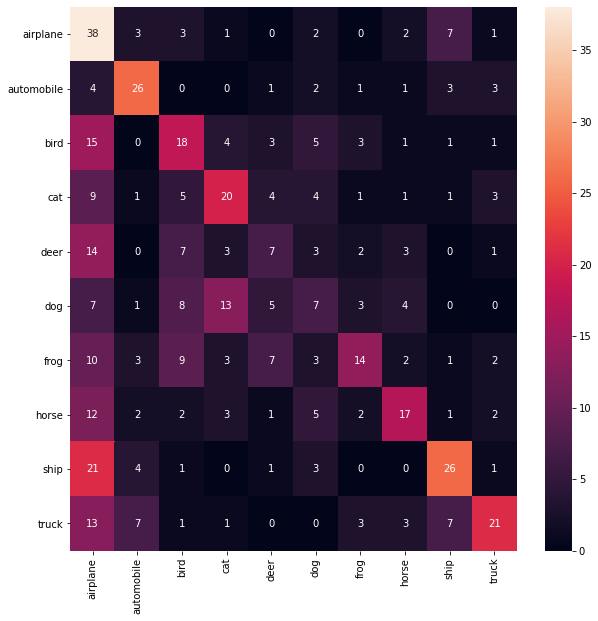

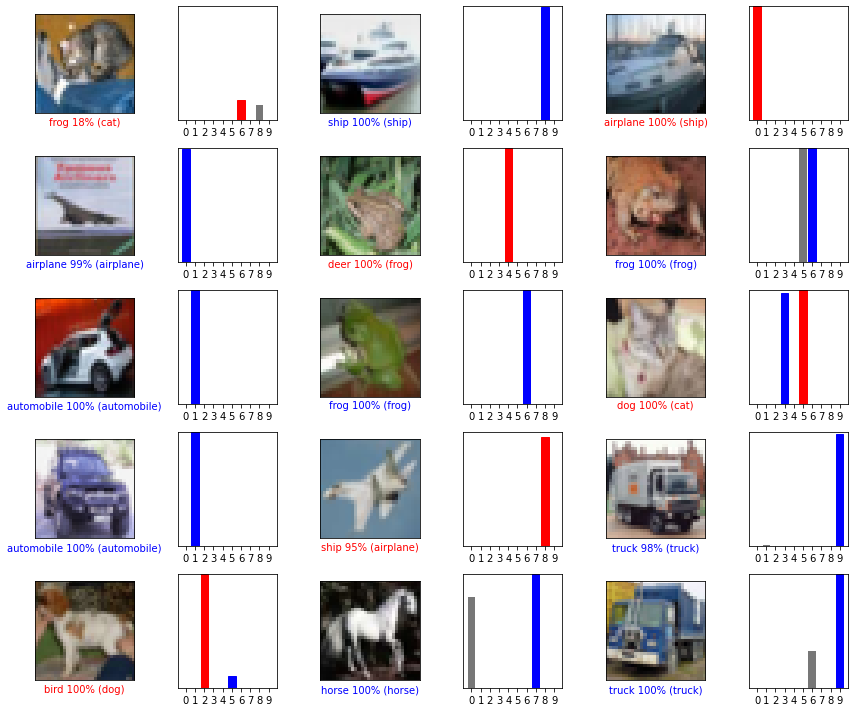

In [ ]:
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(smp_test)))
# Model Accuracy
print('MLP Accuracy is {}%\n'.format(str(round(acc_mlp,2))))
# Processing time
print('Processing time is {} sec\n'.format(str(round(time_mlp_p,2))))
# Model metrics by cat.
print(metrics_mlp)
# Viz Confusion Matrix
conMtxMap(cf_matrix_mlp)
# print raw confusion matrix
print('\n\nRaw Confusion Matrix\n',cf_matrix_mlp,'\n\n')
plot_pred_imgs(prob_mlp, smp_test_label.flatten(), smp_test_plot)

###Prediction | Real World

In [ ]:
rw_lbl, y_pred_rw, prob_rw,img_rw = rw_pred_model('MLP_mod', rw_img, rw_label, class_names)
# Model Accuracy
acc_rw = accuracy_score(rw_lbl, y_pred_rw)
# # -------------------------------------------------------------
metrics_rw = (metrics.classification_report(rw_lbl, y_pred_rw,
                                            target_names= class_names))
# --------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



####Vizualize Results | Real World

Modeled with 50,000 images and tested on 26 images

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00         1
  automobile       0.00      0.00      0.00         2
        bird       0.31      1.00      0.47         8
         cat       0.00      0.00      0.00         2
        deer       0.00      0.00      0.00         2
         dog       0.00      0.00      0.00         1
        frog       0.00      0.00      0.00         4
       horse       0.00      0.00      0.00         2
        ship       0.00      0.00      0.00         2
       truck       0.00      0.00      0.00         2

    accuracy                           0.31        26
   macro avg       0.03      0.10      0.05        26
weighted avg       0.09      0.31      0.14        26

MLP Accuracy On Real World Data 0.31%



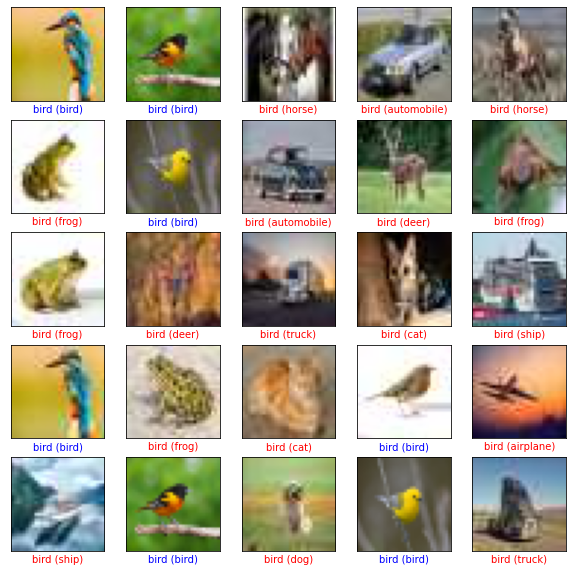

In [ ]:
# ----------------------------------------------------------------------------
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(rw_img)))
print(metrics_rw)
# Model Accuracy
print('MLP Accuracy On Real World Data {}%\n'.format(str(round(acc_rw,2))))
plot_RW([i for i in img_rw][:-1], rw_lbl[:-1], y_pred_rw[:-1])# y_pred_rw[:-1])

# KNN MODEL&#11088;

##Build Model

In [ ]:
starttime = timeit.default_timer()
# ----------------------------------------------------------------------------
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(smp_train, smp_train_label)
sv_name = 'KNN_mod'
# save model
StoreModel(knn,sv_name)
# ----------------------------------------------------------------------------
time_knn = timeit.default_timer() - starttime
# ----------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



##Prediction | Test Data

In [ ]:
starttime = timeit.default_timer()
# load model
model_knn = LoadModel('KNN_mod')
# make predictions
y_pred = model_knn.predict(smp_test)
# get prob. of each model for ploting
prob_knn = model_knn.predict_proba(smp_test)
# ----------------------------------------------------------------------------
# create confusion matrix
expected, predicted = smp_test_label, y_pred
cf_matrix_knn = sklearn.metrics.confusion_matrix(expected, predicted)
# Model Accuracy
acc_knn = metrics.accuracy_score(smp_test_label, y_pred)
# ----------------------------------------------------------------------------
metrics_knn = (metrics.classification_report(smp_test_label, predicted,
                                             target_names= class_names))
# ----------------------------------------------------------------------------
time_knn_p = timeit.default_timer() - starttime
# ----------------------------------------------------------------------------

### Visualize Results | Test Data

Modeled with 50,000 images and tested on 500 images

KNN Accuracy is 0.33%

Processing time is 311.37 sec

              precision    recall  f1-score   support

    airplane       0.42      0.46      0.44        57
  automobile       0.73      0.27      0.39        41
        bird       0.24      0.47      0.32        51
         cat       0.34      0.24      0.29        49
        deer       0.20      0.53      0.29        40
         dog       0.35      0.15      0.21        48
        frog       0.32      0.22      0.26        54
       horse       0.30      0.06      0.11        47
        ship       0.39      0.72      0.51        57
       truck       0.83      0.18      0.29        56

    accuracy                           0.33       500
   macro avg       0.41      0.33      0.31       500
weighted avg       0.42      0.33      0.31       500



Raw Confusion Matrix
 [[26  0  6  0  2  0  3  2 18  0]
 [ 4 11  4  1  7  1  1  0 12  0]
 [ 7  0 24  3 11  3  2  0  1  0]
 [ 1  1 14 

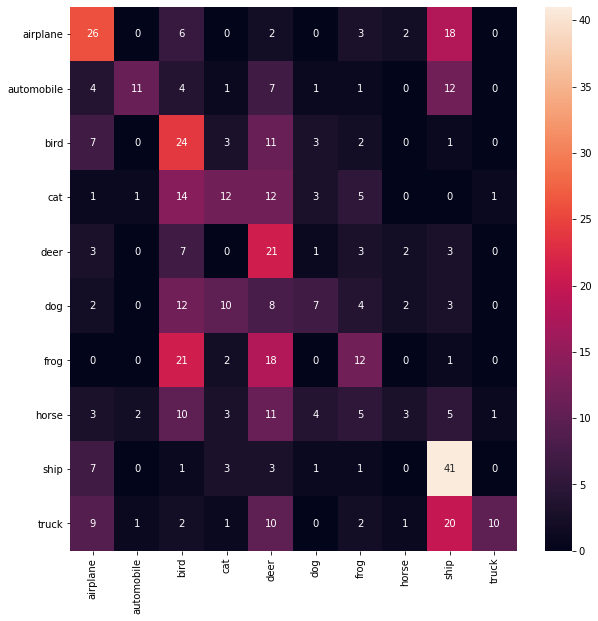

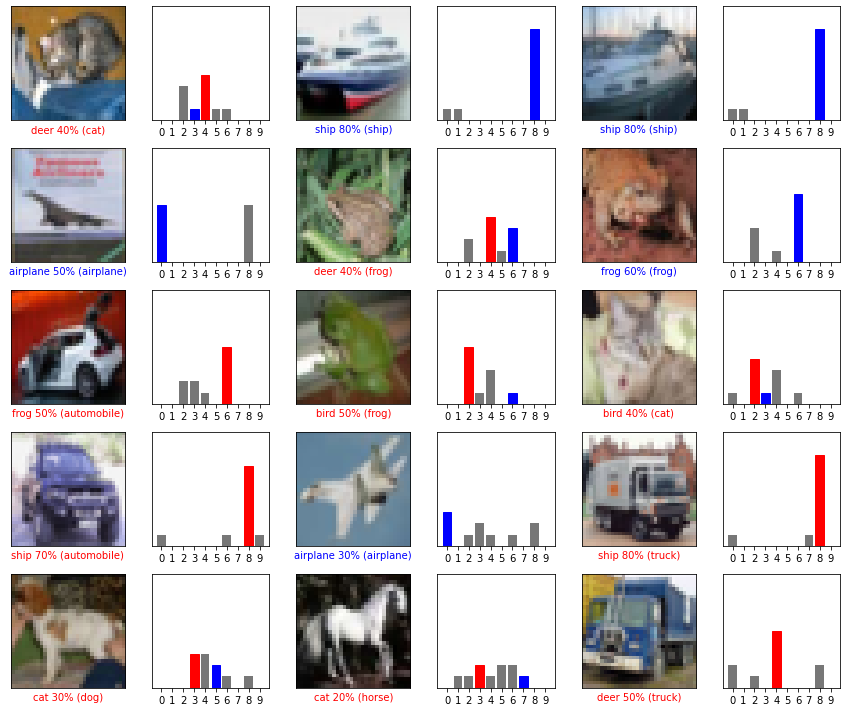

In [ ]:
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(smp_test)))
# Model Accuracy
print('KNN Accuracy is {}%\n'.format(str(round(acc_knn,2))))
# Processing time
print('Processing time is {} sec\n'.format(str(round(time_knn_p,2))))
# Model metrics by cat.
print(metrics_knn)
# Viz Confusion Matrix
conMtxMap(cf_matrix_knn)
# print raw confusion matrix
print('\n\nRaw Confusion Matrix\n',cf_matrix_knn,'\n\n')
plot_pred_imgs(prob_knn, smp_test_label.flatten(), smp_test_plot)

##Prediction | Real World

In [ ]:
rw_lbl, y_pred_rw, prob_rw, img_rw = rw_pred_model('KNN_mod', rw_img, rw_label, class_names)
# Model Accuracy
acc_rw = accuracy_score(rw_lbl, y_pred_rw)

###Visualize Results | Real World

Modeled with 50,000 images and tested on 26 images

KNN Accuracy On Real World Data 0.04%



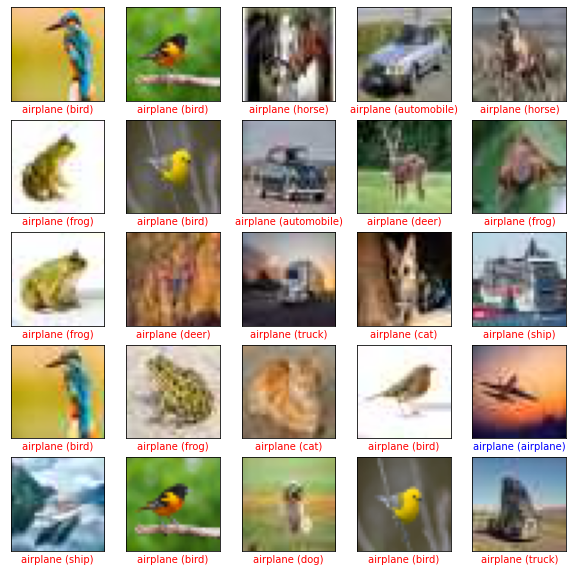

In [ ]:
# ----------------------------------------------------------------------------
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(rw_img)))
# Model Accuracy
print('KNN Accuracy On Real World Data {}%\n'.format(str(round(acc_rw,2))))
plot_RW([i for i in img_rw][:-1], rw_lbl[:-1], y_pred_rw[:-1])

#LINEAR CLASSIFICATION<p>&#11088;</p>

##Build Model

In [ ]:
starttime = timeit.default_timer()
# ----------------------------------------------------------------------------
# Linear Classification
clf = linear_model.SGDClassifier(max_iter=1000)
clf.fit(smp_train, smp_train_label)
# ----------------------------------------------------------------------------
calibrator = CalibratedClassifierCV(clf, cv='prefit')
model      = calibrator.fit(smp_train, smp_train_label)
# ----------------------------------------------------------------------------
sv_name = 'LC_mod'
# save model
# StoreModel(clf,sv_name)
StoreModel(model,sv_name)
# ----------------------------------------------------------------------------
time_lc = timeit.default_timer() - starttime
# ----------------------------------------------------------------------------

##Prediction | Test Data

In [ ]:
# load model
model_clf = LoadModel('LC_mod')
# make predictions
model_clf.score(smp_test, smp_test_label)
y_pred = model_clf.predict(smp_test)
# get prob. of each model for ploting
prob_lc = model_clf.predict_proba(smp_test)
# ----------------------------------------------------------------------------
# create confusion matrix
cf_matrix_lc = sklearn.metrics.confusion_matrix(smp_test_label, y_pred)
# Model Accuracy
acc_lc = metrics.accuracy_score(smp_test_label, y_pred)
# ----------------------------------------------------------------------------
metrics_lc = (metrics.classification_report(smp_test_label, predicted,
                                            target_names= class_names))
# ----------------------------------------------------------------------------
time_lc_p = timeit.default_timer() - starttime
# ----------------------------------------------------------------------------

### Visualize Results | Test Data

Modeled with 50,000 images and tested on 500 images

Linear Classification Accuracy is 0.37%

Processing time is 304.79 sec

              precision    recall  f1-score   support

    airplane       0.51      0.35      0.42        57
  automobile       0.50      0.44      0.47        41
        bird       0.13      0.73      0.22        51
         cat       0.31      0.24      0.27        49
        deer       0.00      0.00      0.00        40
         dog       0.46      0.12      0.20        48
        frog       0.42      0.28      0.33        54
       horse       0.00      0.00      0.00        47
        ship       0.53      0.18      0.26        57
       truck       0.58      0.32      0.41        56

    accuracy                           0.27       500
   macro avg       0.34      0.27      0.26       500
weighted avg       0.36      0.27      0.27       500



Raw Confusion Matrix
 [[19  1  7  0  1  1  3  3 15  7]
 [ 1 18  3  2  0  0  3  2  5  7]
 [ 6  3 12  2  7  6  9  1 

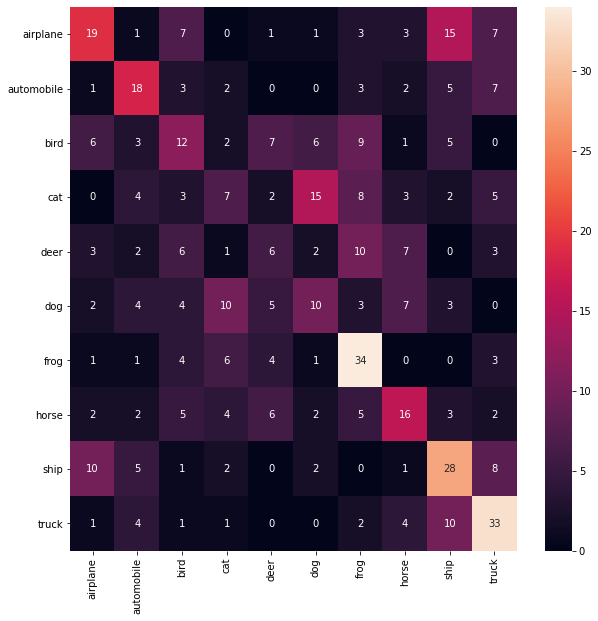

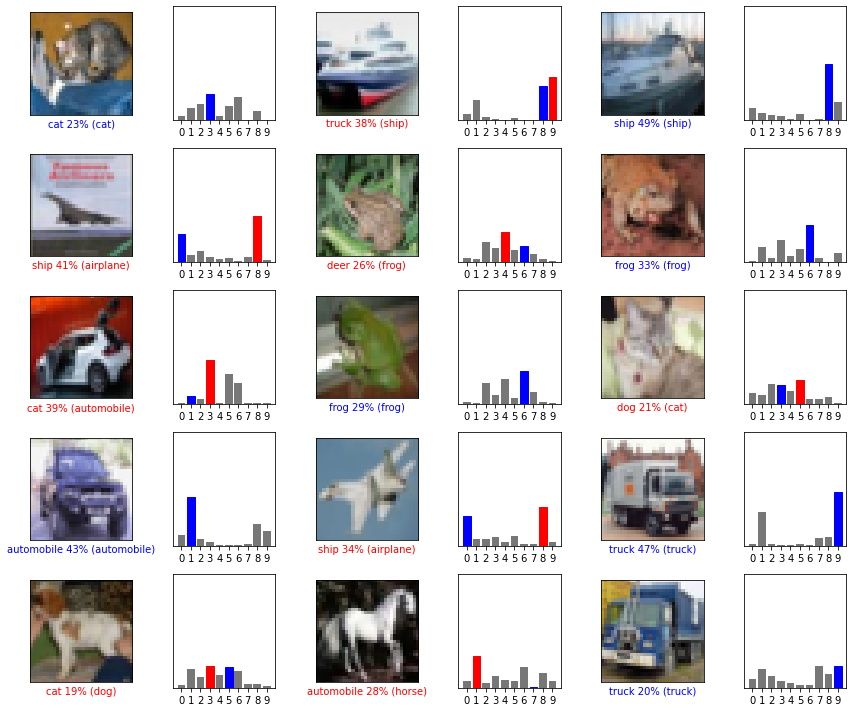

In [ ]:
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(smp_test)))
# Model Accuracy
print('Linear Classification Accuracy is {}%\n'.format(str(round(acc_lc,2))))
# Processing time
print('Processing time is {} sec\n'.format(str(round(time_lc_p,2))))
# MOdel metrics by cat.
print(metrics_lc)
# Viz Confusion Matrix
conMtxMap(cf_matrix_lc)
# print raw confusion matrix
print('\n\nRaw Confusion Matrix\n',cf_matrix_lc,'\n\n')
plot_pred_imgs(prob_lc, smp_test_label.flatten(), smp_test_plot)

##Prediction | Real World

In [ ]:
# ------------------------------------------
rw_lbl, y_pred_rw, img_rw = [], [], []
# ------------------------------------------
for x,i in enumerate(rw_img):
  a = np.array(rw_img[0]).reshape((-1,1)).astype('float32')#.flatten()
  c = a.reshape((a.shape[1], a.shape[0]))
  # ------------------------------------------
  # load model
  model = LoadModel('LC_mod')
  # ------------------------------------------
  # Make predictions
  y_pred = model.predict(c)
  # ------------------------------------------
  y_pred_rw.append(np.argmax(y_pred))
  # ------------------------------------------
  # prob_rw.append(prob)
  rw_lbl.append( class_names.index(rw_label[x]) )
  # ------------------------------------------
  img_rw.append(i)
# ------------------------------------------
acc_rw = metrics.accuracy_score(rw_lbl, y_pred_rw)

###Visualize Results | Real World

Modeled with 50,000 images and tested on 26 images

Linear Classification Accuracy On Real World Data 0.04%



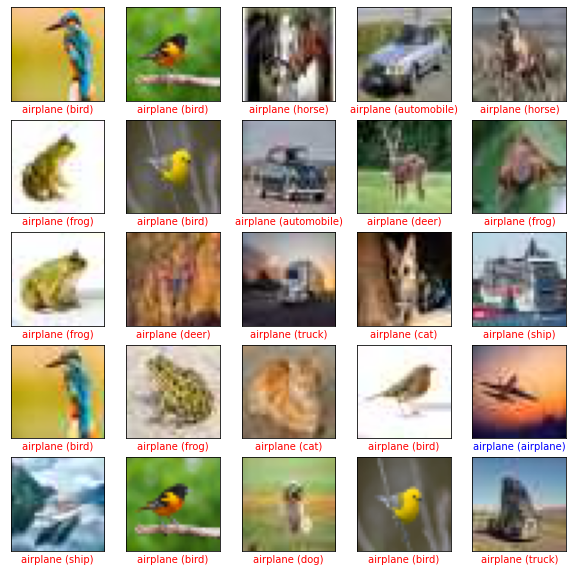

In [ ]:
# ----------------------------------------------------------------------------
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(rw_img)))
# Model Accuracy
print('Linear Classification Accuracy On Real World Data {}%\n'.format(str(round(acc_rw,2))))
plot_RW([i for i in img_rw][:-1], rw_lbl[:-1], y_pred_rw[:-1])

#RANDOM FOREST<p>&#11088;&#11088;</p>

##Build Model

In [ ]:
starttime = timeit.default_timer()
# ----------------------------------------------------------------------------
# Random Forest classifier
forest = RandomForestClassifier(n_estimators = 100)
forest.fit(smp_train, smp_train_label)
sv_name = 'RF_mod'
# save model
StoreModel(forest,sv_name)
# ----------------------------------------------------------------------------
time_rf = timeit.default_timer() - starttime
# ----------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



##Prediction | Test Data

In [ ]:
# load model
model_forest = LoadModel('RF_mod')
# make predictions
y_pred = model_forest.predict(smp_test)
# get prob. of each model for ploting
prob_rf = model_forest.predict_proba(smp_test)
# ----------------------------------------------------------------------------
# create confusion matrix
expected, predicted = smp_test_label, y_pred
cf_matrix_rf = sklearn.metrics.confusion_matrix(expected, predicted)
# Model Accuracy
acc_rf = metrics.accuracy_score(smp_test_label, y_pred)
# ----------------------------------------------------------------------------
metrics_rf = (metrics.classification_report(smp_test_label, predicted,
                                            target_names= class_names))
# ----------------------------------------------------------------------------
time_rf_p = timeit.default_timer() - starttime
# ----------------------------------------------------------------------------

### Visualize Results | Test Data

Modeled with 50,000 images and tested on 500 images

Random Forest Accuracy is 0.44%

Processing time is 400.98 sec

              precision    recall  f1-score   support

    airplane       0.50      0.49      0.50        57
  automobile       0.47      0.54      0.50        41
        bird       0.43      0.41      0.42        51
         cat       0.28      0.29      0.28        49
        deer       0.30      0.35      0.33        40
         dog       0.37      0.27      0.31        48
        frog       0.44      0.46      0.45        54
       horse       0.47      0.36      0.41        47
        ship       0.58      0.54      0.56        57
       truck       0.48      0.61      0.54        56

    accuracy                           0.44       500
   macro avg       0.43      0.43      0.43       500
weighted avg       0.44      0.44      0.44       500



Raw Confusion Matrix
 [[28  2  3  3  1  0  3  1  6 10]
 [ 0 22  0  2  0  1  1  2  4  9]
 [ 8  2 21  5  6  3  4  0  1  1]
 

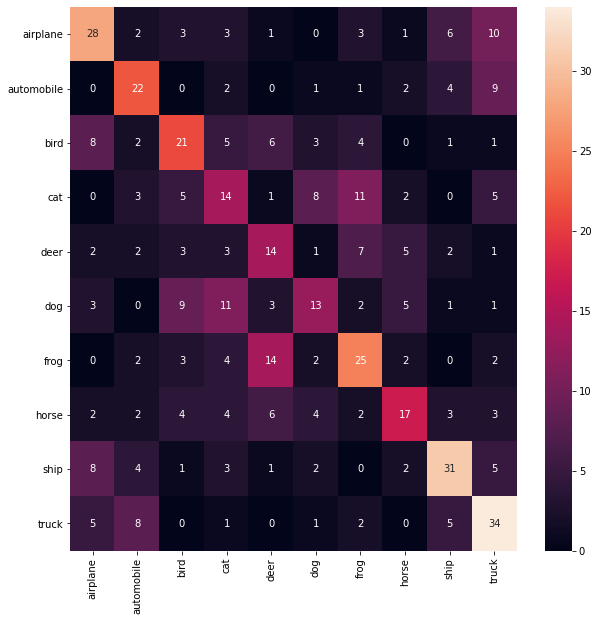

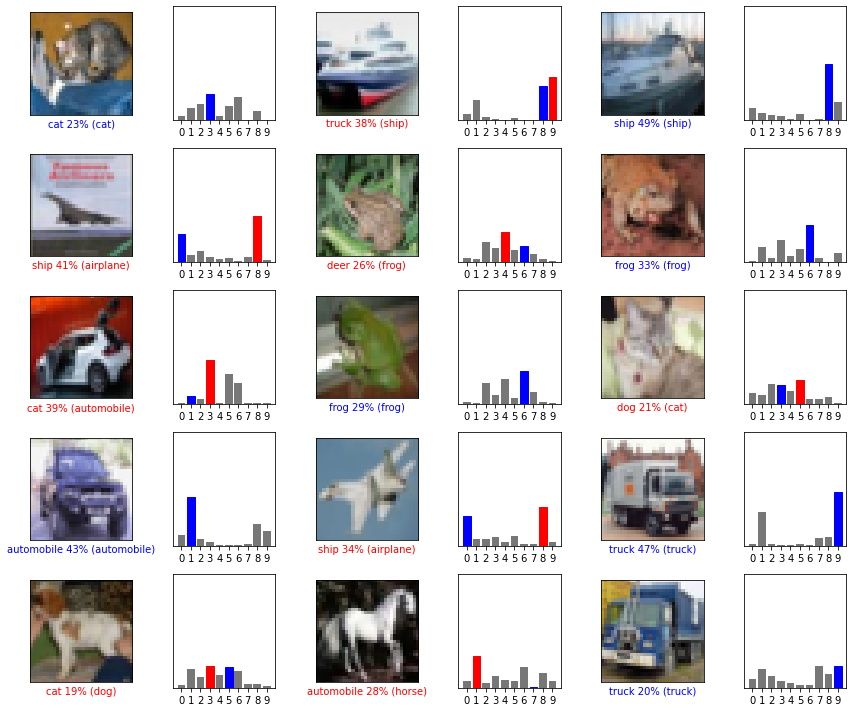

In [ ]:
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(smp_test)))
# Model Accuracy
print('Random Forest Accuracy is {}%\n'.format(str(round(acc_rf,2))))
# Processing time
print('Processing time is {} sec\n'.format(str(round(time_rf_p,2))))
# MOdel metrics by cat.
print(metrics_rf)
# Viz Confusion Matrix
conMtxMap(cf_matrix_rf)
# print raw confusion matrix
print('\n\nRaw Confusion Matrix\n',cf_matrix_rf,'\n\n')
plot_pred_imgs(prob_rf, smp_test_label.flatten(), smp_test_plot)

##Prediction | Real World

In [ ]:
rw_lbl, y_pred_rw, prob_rw,img_rw = rw_pred_model('RF_mod', rw_img, rw_label, class_names)
# Model Accuracy
acc_rw = accuracy_score(rw_lbl, y_pred_rw)

###Visualize Results | Real World

Modeled with 50,000 images and tested on 26 images

Random Forest Accuracy On Real World Data 0.04%



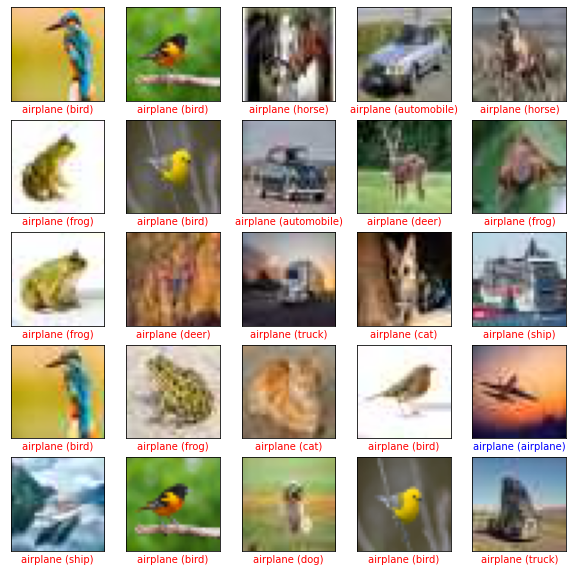

In [ ]:
# ----------------------------------------------------------------------------
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(rw_img)))
# Model Accuracy
print('Random Forest Accuracy On Real World Data {}%\n'.format(str(round(acc_rw,2))))
plot_RW(img_rw[:-1], rw_lbl[:-1], y_pred_rw[:-1])

#NAIVE BAYES<p>&#11088;</p>

##Build Model

In [ ]:
starttime = timeit.default_timer()
# ----------------------------------------------------------------------------
# NB Classifier
gnb = GaussianNB()
# Train our classifier
Mod_gnb = gnb.fit(smp_train, smp_train_label)
sv_name = 'NB_mod'
# save model
StoreModel(Mod_gnb,sv_name)
# ----------------------------------------------------------------------------
time_nb = timeit.default_timer() - starttime
# ----------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



##Prediction | Test Data

In [ ]:
starttime = timeit.default_timer()
# ----------------------------------------------------------------------------
# load model
model_gnb = LoadModel('NB_mod')
# Make predictions
y_pred = model_gnb.predict(smp_test)
# get prob. of each model for ploting
prob_nb = model_gnb.predict_proba(smp_test)
# ----------------------------------------------------------------------------
# create confusion matrix
expected, predicted = smp_test_label, y_pred
cf_matrix_nb = sklearn.metrics.confusion_matrix(expected, predicted)
# Model Accuracy
acc_nb = metrics.accuracy_score(smp_test_label, y_pred)
# ----------------------------------------------------------------------------
time_nb = timeit.default_timer() - starttime
# ----------------------------------------------------------------------------
metrics_nb = (metrics.classification_report(smp_test_label, predicted,
                                            target_names= class_names))
# ----------------------------------------------------------------------------
time_nb_p = timeit.default_timer() - starttime
# ----------------------------------------------------------------------------

### Visualize Results | Test Data

Modeled with 50,000 images and tested on 500 images

Naive Bayes Accuracy is 0.28%

Processing time is 0.19 sec

              precision    recall  f1-score   support

    airplane       0.26      0.42      0.32        57
  automobile       0.35      0.20      0.25        41
        bird       0.19      0.10      0.13        51
         cat       0.06      0.02      0.03        49
        deer       0.18      0.33      0.23        40
         dog       0.26      0.21      0.23        48
        frog       0.32      0.52      0.40        54
       horse       0.27      0.06      0.10        47
        ship       0.38      0.49      0.43        57
       truck       0.37      0.39      0.38        56

    accuracy                           0.28       500
   macro avg       0.26      0.27      0.25       500
weighted avg       0.27      0.28      0.26       500



Raw Confusion Matrix
 [[24  1  2  1  1  0  6  0 12 10]
 [ 4  8  0  1  4  3  8  1  7  5]
 [13  1  5  1 14  5  7  1  3  1]
 [ 8 

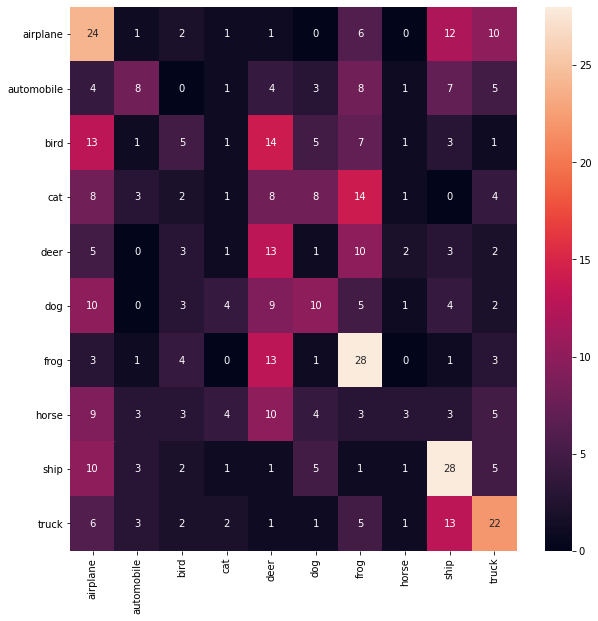

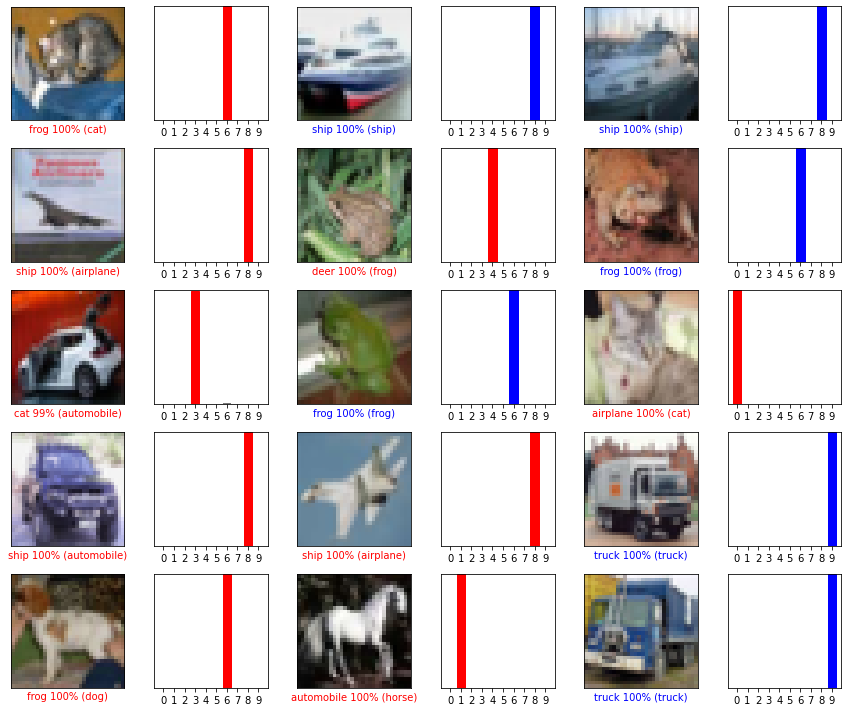

In [ ]:
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(smp_test)))
# Model Accuracy
print('Naive Bayes Accuracy is {}%\n'.format(str(round(acc_nb,2))))
# Processing time
print('Processing time is {} sec\n'.format(str(round(time_nb_p,2))))
# MOdel metrics by cat.
print(metrics_nb)
# Viz Confusion Matrix
conMtxMap(cf_matrix_nb)
# print raw confusion matrix
print('\n\nRaw Confusion Matrix\n',cf_matrix_nb,'\n\n')
plot_pred_imgs(prob_nb, smp_test_label.flatten(), smp_test_plot)



---



##Prediction | Real World

In [ ]:
rw_lbl, y_pred_rw, prob_rw, img_rw = rw_pred_model('NB_mod', rw_img, rw_label, class_names)
# Model Accuracy
acc_rw = accuracy_score(rw_lbl, y_pred_rw)

###Visualize Results | Real World

Modeled with 50,000 images and tested on 26 images

Naive Bayes Accuracy On Real World Data 0.04%



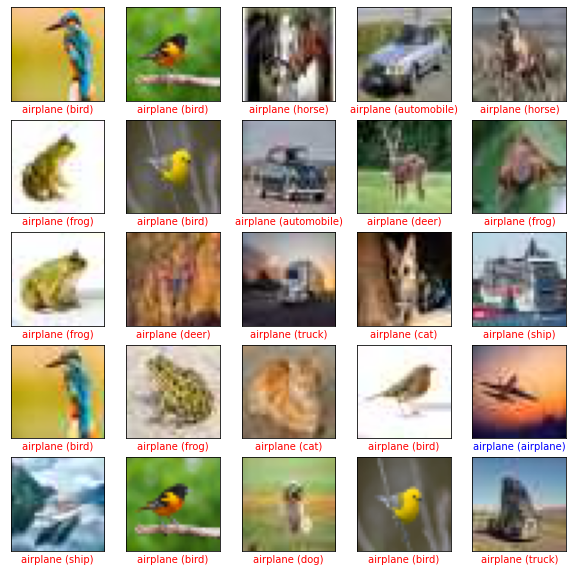

In [ ]:
# ----------------------------------------------------------------------------
# Sampled number of images
print('Modeled with {0:,} images and tested on {1:,} images\n'.format(len(smp_train),len(rw_img)))
# Model Accuracy
print('Naive Bayes Accuracy On Real World Data {}%\n'.format(str(round(acc_rw,2))))
plot_RW(img_rw[:-1], rw_lbl[:-1], y_pred_rw[:-1])

#Model Accuracy

In [ ]:
acc = {'KNN':[round(acc_knn*100,2)], 'LC':[round(acc_lc*100,2)],
      'NB':[round(acc_nb*100,2)], 'RF':[round(acc_rf*100,2)]}
             
Mod_Performance = pd.DataFrame.from_dict(acc).transpose()
Mod_Performance['Model'] = Mod_Performance.index
Mod_Performance.columns = ['Accuracy','Model']
print(Mod_Performance.to_markdown())
Mod_Performance.to_csv("{0}Mod_Performance.csv".format(root_path))

|     |   Accuracy | Model   |
|:----|-----------:|:--------|
| KNN |       33.4 | KNN     |
| LC  |       22.4 | LC      |
| NB  |       28.4 | NB      |
| RF  |       48.4 | RF      |


In [ ]:
# -----------------------------------------------
Mod_P = pd.read_csv("{0}Mod_Performance.csv".format(root_path))
# -----------------------------------------------
acc2 = {'CNN':[round(acc_cnn*100,2)], 'MLP':[round(acc_mlp*100,2)]}
Mod = pd.DataFrame.from_dict(acc2).transpose()
Mod['Model'] = Mod.index
Mod.columns = ['Accuracy','Model']
# ------------------------------------------------
Mod_Performance = pd.concat([Mod, Mod_P], axis=0)
# ------------------------------------------------
print(Mod_Performance.to_markdown())

|     |   Accuracy | Model   | Unnamed: 0   |
|:----|-----------:|:--------|:-------------|
| CNN |      82.85 | CNN     | nan          |
| MLP |      38.8  | MLP     | nan          |
| 0   |      33.4  | KNN     | KNN          |
| 1   |      22.4  | LC      | LC           |
| 2   |      28.4  | NB      | NB           |
| 3   |      48.4  | RF      | RF           |


##Model Performance Graph&#10024;

In [ ]:
fig = px.bar(Mod_Performance, x='Model', y='Accuracy',
             hover_data=['Accuracy','Model'], color='Accuracy',text='Accuracy')
fig.update_traces(texttemplate='%{text:.2s}%', textposition='outside')
fig.show()

#Model Compute Performance

In [ ]:
tm = {'KNN':[round(time_knn,2)], 'LC':[round(time_lc,2)],
      'NB':[round(time_nb,2)], 'RF':[round(time_rf,2)]}
Compute_Time = pd.DataFrame.from_dict(tm).transpose()
Compute_Time['Model'] = Compute_Time.index
Compute_Time.columns = ['Compute','Model']
print(Compute_Time.to_markdown())
Compute_Time.to_csv("{0}Compute_Time.csv".format(root_path))

|     |   Compute | Model   |
|:----|----------:|:--------|
| KNN |     57.04 | KNN     |
| LC  |     29.98 | LC      |
| NB  |      0.99 | NB      |
| RF  |    240.87 | RF      |


In [ ]:
# -----------------------------------------------
Mod_P = pd.read_csv("{0}Compute_Time.csv".format(root_path))
# -----------------------------------------------
acc2 = {'CNN':[round(time_cnn,2)], 'MLP':[round(time_mlp,2)]}
Mod = pd.DataFrame.from_dict(acc2).transpose()
Mod['Model'] = Mod.index
Mod.columns = ['Compute','Model']
# ------------------------------------------------
Compute_Time = pd.concat([Mod, Mod_P], axis=0)
# ------------------------------------------------
print(Compute_Time.to_markdown())

|     |   Compute | Model   | Unnamed: 0   |
|:----|----------:|:--------|:-------------|
| CNN |    966.83 | CNN     | nan          |
| MLP |   2921.47 | MLP     | nan          |
| 0   |     57.04 | KNN     | KNN          |
| 1   |     29.98 | LC      | LC           |
| 2   |      0.99 | NB      | NB           |
| 3   |    240.87 | RF      | RF           |


In [ ]:
# -----------------------------------------------
Mod_P = pd.read_csv("{0}Compute_Time_P.csv".format(root_path))
# -----------------------------------------------
acc2 = {'CNN':[round(time_cnn_p,2)], 'MLP':[round(time_mlp_p,2)]}
Mod = pd.DataFrame.from_dict(acc2).transpose()
Mod['Model'] = Mod.index
Mod.columns = ['Compute_p','Model']
# ------------------------------------------------
Compute_Time_P = pd.concat([Mod, Mod_P], axis=0)
# ------------------------------------------------
print(Compute_Time_P.to_markdown())

|     |   Compute_p | Model   | Unnamed: 0   |
|:----|------------:|:--------|:-------------|
| CNN |        2.42 | CNN     | nan          |
| MLP |        0.07 | MLP     | nan          |
| 0   |      297.65 | KNN     | KNN          |
| 1   |      219.65 | LC      | LC           |
| 2   |        4.28 | NB      | NB           |
| 3   |      357.74 | RF      | RF           |


##Model Build Compute Graph&#10024;

In [ ]:
fig = px.bar(Compute_Time, x='Model', y='Compute',
             hover_data=['Compute','Model'], color='Compute',text='Compute')
fig.update_traces(texttemplate='%{text:.2s} sec', textposition='outside')
fig.show()



---





---



---



---



# JUNK CODE



---



##Single Image Prediction
*   Use the trained model
*   Finally, use the trained model to make a prediction about a single image.

In [ ]:
# # Grab an image from the test dataset.
# img = test_images[1]
# print(img.shape)
# # Add the image to a batch where it's the only member.
# img = (np.expand_dims(img,0))
# print(img.shape)
# predictions_single = probability_model.predict(img)
# print(predictions_single)
# #Grab the predictions for our (only) image in the batch:
# np.argmax(predictions_single[0])

In [ ]:
# def rw_pred_model(mod,rw_img,rw_label,class_names):
#   # ------------------------------------------
#   rw_lbl, y_pred_rw, prob_rw = [], [], []
#   # ------------------------------------------
#   for x,i in enumerate(rw_img):
#     a = np.array(rw_img[0]).reshape((-1,1)).astype('float32')#.flatten()
#     c = a.reshape((a.shape[1], a.shape[0]))
#     # ------------------------------------------
#     # load model
#     model = LoadModel(mod)
#     # ------------------------------------------
#     # Make predictions
#     y_pred = model.predict(c)
#     # ------------------------------------------
#     # get prob. of each model for ploting
#     prob = model.predict_proba(c)
#     # ------------------------------------------
#     y_pred_rw.append(np.argmax(y_pred))
#     prob_rw.append(prob)
#     rw_lbl.append( class_names.index(rw_label[x]) )
#     # ------------------------------------------
#   return(rw_lbl, y_pred_rw, prob_rw)
#     # ------------------------------------------



---



### website code

In [ ]:
# from numpy import mean
# from numpy import std
# from matplotlib import pyplot
# from sklearn.model_selection import KFold
# from keras.datasets import fashion_mnist
# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.optimizers import SGD
 
# # load train and test dataset
# def load_dataset():
# 	# load dataset
# 	(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
# 	# reshape dataset to have a single channel
# 	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
# 	testX = testX.reshape((testX.shape[0], 28, 28, 1))
# 	# one hot encode target values
# 	trainY = to_categorical(trainY)
# 	testY = to_categorical(testY)
# 	return trainX, trainY, testX, testY
 
# # scale pixels
# def prep_pixels(train, test):
# 	# convert from integers to floats
# 	train_norm = train.astype('float32')
# 	test_norm = test.astype('float32')
# 	# normalize to range 0-1
# 	train_norm = train_norm / 255.0
# 	test_norm = test_norm / 255.0
# 	# return normalized images
# 	return train_norm, test_norm
 
# # define cnn model
# def define_model():
# 	model = Sequential()
# 	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
# 	model.add(MaxPooling2D((2, 2)))
# 	model.add(Flatten())
# 	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
# 	model.add(Dense(10, activation='softmax'))
# 	# compile model
# 	opt = SGD(lr=0.01, momentum=0.9)
# 	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# 	return model
 
# # evaluate a model using k-fold cross-validation
# def evaluate_model(dataX, dataY, n_folds=8):
# 	scores, histories = list(), list()
# 	# prepare cross validation
# 	kfold = KFold(n_folds, shuffle=True, random_state=1)
# 	# enumerate splits
# 	for train_ix, test_ix in kfold.split(dataX):
# 		# define model
# 		model = define_model()
# 		# select rows for train and test
# 		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
# 		# fit model
# 		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
# 		# evaluate model
# 		_, acc = model.evaluate(testX, testY, verbose=0)
# 		print('> %.3f' % (acc * 100.0))
# 		# append scores
# 		scores.append(acc)
# 		histories.append(history)
# 	return scores, histories
 
# # plot diagnostic learning curves
# def summarize_diagnostics(histories):
# 	for i in range(len(histories)):
# 		# plot loss
# 		plt.subplot(211)
# 		plt.title('Cross Entropy Loss')
# 		plt.plot(histories[i].history['loss'], color='blue', label='train')
# 		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
# 		# plot accuracy
# 		plt.subplot(212)
# 		plt.title('Classification Accuracy')
# 		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
# 		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
# 	plt.show()
 
# # summarize model performance
# def summarize_performance(scores):
# 	# print summary
# 	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
# 	# box and whisker plots of results
# 	plt.boxplot(scores)
# 	plt.show()
 
# # run the test harness for evaluating a model
# def run_test_harness():
# 	# load dataset
# 	trainX, trainY, testX, testY = load_dataset()
# 	# prepare pixel data
# 	trainX, testX = prep_pixels(trainX, testX)
# 	# evaluate model
# 	scores, histories = evaluate_model(trainX, trainY)
# 	# learning curves
# 	summarize_diagnostics(histories)
# 	# summarize estimated performance
# 	summarize_performance(scores)
 
# # entry point, run the test harness
# run_test_harness()

### disposed code

In [ ]:
# scale pixels
# def rw_prep_pixels(test):
#   # -----------------  
#   # long output omitted
#   # test = np.array([np.zeros(i) for i in test_imgs])
#   # -----------------
#   # test = np.array(test)
#   # -----------------
#   # test  = np.array([i for i in test])
#   test  = [np.array(i.reshape((i.shape[0],-1)).astype('float32')/255) for i in test]
  
#   # test  = [i.flatten() for i in test]  
#   # test  = [np.zeros(test).astype(object)]
# 	# return normalized images
#   return(test)
# cifar10 = keras.datasets.cifar10
# # load the data into testing and training sets_cnn giving issues last min
# (train_img, train_L), (test_img, test_L) = cifar10.load_data()
# # #--------------------------------------------
# # FLATTEN 28 x 28 IMAGE TO 784 VECTOR
# num_pixels = train_img.shape[1] * train_img.shape[2]
# # --------------------------------------------
# #Reshape based on multipled vector with each pixel as a float
# train = train_img.reshape(train_img.shape[0], num_pixels).astype('float32')
# test  = test_img.reshape(test_img.shape[0], num_pixels).astype('float32')
# # --------------------------------------------
# # --------------------------------------------
# # # Reshape based on multipled vector with each pixel as a float
# # train = train_img.reshape(train_img.shape[0], -1).T.astype('float32')
# # test  = test_img.reshape(test_img.shape[0], -1).T.astype('float32')
# # # --------------------------------------------
# # Normalize pixels from 0-1
# train = train / 255
# test = test / 255
# # --------------------------------------------
# # SCRUB
# # THE OLD ONE HOT ENCODE - CONVERT "CATEGORICAL" CLASSIFICATION TO ENCODE
# # A "BINARIZATION" OF THE CATEGORIES
# y_train = np_utils.to_categorical(y_train) #labels
# y_test = np_utils.to_categorical(y_test)
# num_classes = y_test.shape[1]

# train_images = train_images.reshape([-1, 28, 28, 1])
# test_images = test_images.reshape([-1, 28, 28, 1])
# train_images = train_images/255
# test_images = test_images/255
# from PIL import Image

# # new_height = 32
# # new_width = new_height / image.height * image.width

# for img in os.listdir(folder):
#   with open(folder + img, 'r+b') as f:
#     with Image.open(f) as image:
#       new_height = 1024
#       new_width = int(new_height / image.height * image.width)
#       new_size = image.resize(new_width,new_height)
#       print(new_size)
#       # cover = resizeimage.resize_cover(image, [32,32])
#       # cover.save(folder + img, image.format)
# X_flatten.shape
# X_flatten = train_images.reshape(train_images.shape[0], -1).T

In [ ]:
# # --------------------------------------------
# # Specifiy the dataset wanted
# fashion_mnist = keras.datasets.fashion_mnist
# # load the data into testing and training sets
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# # --------------------------------------------
# --------------------------------------------
# # FLATTEN 28 x 28 IMAGE TO 784 VECTOR
# num_pixels = train_images.shape[1] * train_images.shape[2]
# # --------------------------------------------
# # Reshape based on multipled vector with each pixel as a float
# train = train_images.reshape(train_images.shape[0], num_pixels).astype('float32')
# test  = test_images.reshape(test_images.shape[0], num_pixels).astype('float32')
# # --------------------------------------------
# # Normalize pixels from 0-1
# train = train / 255
# test = test / 255
# # --------------------------------------------

In [ ]:
# # train flatten to 2d
# nsamples, nx, ny = train_images.shape
# d2_train_dataset = train_images.reshape((nsamples,nx*ny))

# # test flatten to 2d
# nsamples, nx, ny = test_images.shape
# d2_test_dataset = test_images.reshape((nsamples,nx*ny))

# # NORMALIZE INPUTS FROM RGB COLOR TO 0-1 --- Professor code
# train = d2_train_dataset / 255
# test  = d2_test_dataset / 255

# # Reshape to 3d
# train_reshp = [np.reshape(i,(28,28)) for i in train]
# test_reshp  = [np.reshape(i,(28,28)) for i in test]

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.datasets import fetch_olivetti_faces
# from sklearn.utils.validation import check_random_state

# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import RidgeCV

# # Load the faces datasets
# data, targets = fetch_olivetti_faces(return_X_y=True)

# train = data[targets < 30]
# test = data[targets >= 30]  # Test on independent people

# # Test on a subset of people
# n_faces = 5
# rng = check_random_state(4)
# face_ids = rng.randint(test.shape[0], size=(n_faces, ))
# test = test[face_ids, :]

# n_pixels = data.shape[1]
# # Upper half of the faces
# X_train = train[:, :(n_pixels + 1) // 2]
# # Lower half of the faces
# y_train = train[:, n_pixels // 2:]
# X_test = test[:, :(n_pixels + 1) // 2]
# y_test = test[:, n_pixels // 2:]

# Fit estimators
# ESTIMATORS = {
#     "Extra trees": ExtraTreesRegressor(n_estimators=10, max_features=32,
#                                        random_state=0),
#     "K-nn": KNeighborsRegressor(),
#     "Linear regression": LinearRegression(),
#     "Ridge": RidgeCV(),
# }

# y_test_predict = dict()
# for name, estimator in ESTIMATORS.items():
#     estimator.fit(X_train, y_train)
#     y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
# image_shape = (64, 64)

# n_cols = 1 + len(ESTIMATORS)
# plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
# plt.suptitle("Face completion with multi-output estimators", size=16)


Text(0.5, 0.98, 'Face completion with multi-output estimators')

<Figure size 720x813.6 with 0 Axes>

In [ ]:
# # extract a small sample for quick model running and testing
# import random
# SEED = 2

# ls1 = [ 'list', 'elements', 'go', 'here' ]
# ls2 = [5,6,7,8]
# random.seed(SEED)
# random.shuffle(ls1)
# random.shuffle(ls2)

# print(ls1,ls2)

####disposed single cnn

In [ ]:
# starttime = timeit.default_timer()
# # --------------------------------------------------------------
# # Build Model
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(32, 32, 3)),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(10)])
# # --------------------------------------------------------------
# # Compile Model
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# # Fit model to trining images with labels
# history = model.fit(train_img, train_L, epochs=10, 
#                     validation_data=(test_img, test_L))
# # Evaluate model
# test_loss, acc_cnn = model.evaluate(test_img,  test_L, verbose=2)
# # View Accuracy of model
# # print('\n10 Epochs Testings Accuracy is:', acc_cnn)
# # --------------------------------------------------------------
# #     ---------------- MAKE PREDICTIONS --------------------   #
# # --------------------------------------------------------------
# probability_model = tf.keras.Sequential([model, 
#                                          tf.keras.layers.Softmax()])
# # --------------------------------------------------------------
# # Predict aginst test images based on CNN Model
# predictions = probability_model.predict(test_img)
# # --------------------------------------------------------------
# expected, predicted = test_L, [np.argmax(i) for i in predictions] # np.argmas gets max element
# # --------------------------------------------------------------

# time_cnn = timeit.default_timer() - starttime

In [ ]:
# def define_model(trainX, trainY, testX, testY,epoch_count):
# 	model = Sequential()
# 	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
# 	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(MaxPooling2D((2, 2)))
# 	model.add(Dropout(0.2))
# 	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(MaxPooling2D((2, 2)))
# 	model.add(Dropout(0.2))
# 	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(MaxPooling2D((2, 2)))
# 	model.add(Dropout(0.2))
# 	model.add(Flatten())
# 	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# 	model.add(Dropout(0.2))
# 	model.add(Dense(10, activation='softmax'))
# 	# compile model
# 	opt = SGD(lr=0.001, momentum=0.9)
# 	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# 	# return model
# 	# -----------------------------
# 	# create data generator
# 	datagen = ImageDataGenerator(width_shift_range=0.1,
# 	                             height_shift_range=0.1,horizontal_flip=True)
# 	# prepare iterator
# 	it_train = datagen.flow(trainX, trainY, batch_size=64)
# 	# fit model
# 	steps = int(trainX.shape[0] / 64)
# 	model = model.fit_generator(it_train, steps_per_epoch=steps,
# 	                             epochs=epoch_count,validation_data=(testX, testY),
# 															               verbose=0) ; return(model)
# 	# return(model)
	

# # define cnn model
# def define_model():
# 	model = Sequential()
# 	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
# 	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(MaxPooling2D((2, 2)))
# 	model.add(Dropout(0.2))
# 	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(MaxPooling2D((2, 2)))
# 	model.add(Dropout(0.2))
# 	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
# 	model.add(MaxPooling2D((2, 2)))
# 	model.add(Dropout(0.2))
# 	model.add(Flatten())
# 	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# 	model.add(Dropout(0.2))
# 	model.add(Dense(10, activation='softmax'))
# 	# compile model
# 	opt = SGD(lr=0.001, momentum=0.9)
# 	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# 	return model

# def build_model(trainX, trainY, testX, testY,epoch_count):
# 	model = define_model()
# 	# create data generator
# 	datagen = ImageDataGenerator(width_shift_range=0.1, 
# 																height_shift_range=0.1, 
# 																							horizontal_flip=True)
# 	# prepare iterator
# 	it_train = datagen.flow(trainX, trainY, batch_size=64)
# 	# fit model
# 	steps = int(trainX.shape[0] / 64)
# 	history = model.fit_generator(it_train, steps_per_epoch=steps,
# 	                              epochs=epoch_count,
# 																               validation_data=(testX, testY),
# 																							        verbose=0)

# 	return(history)

# # evaluate a model using k-fold cross-validation
# def evaluate_model_cnn(model, dataX, dataY, n_folds=2):
# 	scores, histories = list(), list()
# 	# prepare cross validation
# 	kfold = KFold(n_folds, shuffle=True, random_state=1)
# 	# enumerate splits
# 	for train_ix, test_ix in kfold.split(dataX):
# 		# define model
# 		model = define_model(trainX, trainY, testX, testY,epoch_count)
# 		# select rows for train and test
# 		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
# 		# fit model
# 		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
# 		# evaluate model
# 		_, acc = model.evaluate(testX, testY, verbose=0)
# 		print('> %.3f' % (acc * 100.0))
# 		# append scores
# 		scores.append(acc)
# 		# histories.append(history)
# 	return (scores, histories)

# # evaluate a model using k-fold cross-validation
# def evaluate_model(dataX, dataY, n_folds=2):
# 	scores, histories = list(), list()
# 	# prepare cross validation
# 	kfold = KFold(n_folds, shuffle=True, random_state=1)
# 	# enumerate splits
# 	for train_ix, test_ix in kfold.split(dataX):
# 		# define model
# 		model = define_model()
# 		# select rows for train and test
# 		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
# 		# fit model
# 		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
# 		# evaluate model
# 		_, acc = model.evaluate(testX, testY, verbose=0)
# 		print('> %.3f' % (acc * 100.0))
# 		# append scores
# 		scores.append(acc)
# 		histories.append(history)
# 	return scores, histories